In [ ]:
%load_ext autoreload
%autoreload 2

from nbdev import *
from fastcore.test import *
from rory.core import *
from fastai2.vision.all import *
import pandas as pd
%nbdev_default_export bboxes

Cells will be exported to rory.bboxes,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Data prep (almost no fastai usage)
> Working my way up from single object classification to multi object segmentation with fastai2.

In [ ]:
path = Path('/home/rory/data/coco2017')
zipfiles = path.ls(); zipfiles

(#11) [Path('/home/rory/data/coco2017/models'),Path('/home/rory/data/coco2017/image_info_test2017.zip'),Path('/home/rory/data/coco2017/train2017.zip'),Path('/home/rory/data/coco2017/test2017'),Path('/home/rory/data/coco2017/val2017'),Path('/home/rory/data/coco2017/train2017'),Path('/home/rory/data/coco2017/data.csv'),Path('/home/rory/data/coco2017/annotations_trainval2017.zip'),Path('/home/rory/data/coco2017/annotations'),Path('/home/rory/data/coco2017/test2017.zip')...]

Import deps for unzip().

In [ ]:
def unzip(*posixpaths,dest):
    """Unzips files located at posixpaths to dest. Deps: zipfile, pathlib."""
    for path in posixpaths:
        if path.suffix == '.zip':
            print(f"Unzipping: {path} ---> {dest}.")
            with ZipFile(path, 'r') as archive:
                archive.extractall(dest)
    print("Finished. Files in dest:")
    printnl(*dest.ls(), 1)

Uncomment the cell below if this is the first time running.

In [ ]:
# unzip(*zipfiles, dest=path)

Fastai's helper function for getting COCO formatted labels out of their weird json structure.

In [ ]:
img_t, lbls_t = get_annotations(path/'annotations/instances_train2017.json')
img_v, lbls_v = get_annotations(path/'annotations/instances_val2017.json'); printnl(img_v[0],lbls_v[0])

000000397133.jpg

([[217.62, 240.54, 256.61, 298.28999999999996], [1.0, 240.24, 347.63, 427.0], [388.66, 69.92, 498.07000000000005, 347.54], [135.57, 249.43, 157.89, 278.22], [31.28, 344.0, 99.4, 384.83], [59.63, 287.36, 135.7, 328.66], [1.36, 164.33, 193.92000000000002, 262.70000000000005], [0.0, 262.81, 62.16, 299.58], [119.4, 272.51, 144.22, 306.76], [141.47, 267.91, 173.66, 303.77000000000004], [155.97, 168.95, 182.0, 186.07999999999998], [157.2, 114.15, 175.06, 129.97], [98.75, 304.78, 109.53, 310.34999999999997], [166.03, 256.36, 174.85, 274.94], [86.41, 293.97, 110.37, 305.15000000000003], [70.14, 296.16, 79.42, 300.74], [0.0, 210.9, 191.36, 309.88], [96.69, 297.09, 104.53, 301.95], [497.25, 203.4, 619.26, 232.01]], ['bottle', 'dining table', 'person', 'knife', 'bowl', 'bowl', 'oven', 'person', 'cup', 'cup', 'bowl', 'bowl', 'broccoli', 'spoon', 'broccoli', 'broccoli', 'oven', 'carrot', 'sink'])


In [ ]:
img_t = list(map(lambda x: 'train2017/'+x,img_t))
img_v = list(map(lambda x: 'val2017/'+x,img_v)); img_v[0:3]

['val2017/000000397133.jpg',
 'val2017/000000037777.jpg',
 'val2017/000000252219.jpg']

I'll use pandas to create the src dataset. I want the fields (file, labels, bboxes, is_val).

In [ ]:
img = img_t + img_v
lbls = lbls_t + lbls_v
bbs = [i[0] for i in lbls_t] + [i[0] for i in lbls_v]
cls = [i[1] for i in lbls_t] + [i[1] for i in lbls_v]
is_val = [False]*len(img_t) + [True]*len(img_v)

Grab largest label.

In [ ]:
def list_T(l): return list(zip(l[0],l[1]))

In [ ]:
lbls_T=list_T(lbls[0])
print(len(lbls[0]), len(lbls_T))

2 4


In [ ]:
lbls[0:1]

[([[359.17, 146.17, 471.62, 359.74],
   [339.88, 22.16, 493.76, 322.89000000000004],
   [471.64, 172.82, 507.56, 220.92],
   [486.01, 183.31, 516.64, 218.29]],
  ['motorcycle', 'person', 'person', 'bicycle'])]

In [ ]:
lbls_T[0:4]

[([359.17, 146.17, 471.62, 359.74], 'motorcycle'),
 ([339.88, 22.16, 493.76, 322.89000000000004], 'person'),
 ([471.64, 172.82, 507.56, 220.92], 'person'),
 ([486.01, 183.31, 516.64, 218.29], 'bicycle')]

In [ ]:
def get_bb_area(lbl):
    b = lbl[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r

In [ ]:
e = get_bb_area(([146.17, 359.17, 359.74, 471.62], 'motorcycle')); e

24015.9465

In [ ]:
def get_lrg_lbl(o): 
    l = list_T(o)
    l = sorted(l, key=get_bb_area, reverse=True)
    return list(l[0])

In [ ]:
lrg = [get_lrg_lbl(l) for l in lbls] ; lrg[0:1]

[[[339.88, 22.16, 493.76, 322.89000000000004], 'person']]

In [ ]:
lrg_bb = [i[0] for i in lrg]
lrg_cls = [i[1] for i in lrg]

In [ ]:
dfd = {
    "img":img,
    "lbls":lbls,
    "bbs":bbs,
    "cls":cls,
    "lrg":lrg,
    "lrg_bb":lrg_bb,
    "lrg_cls":lrg_cls,
    "is_val":is_val
}

In [ ]:
df = pd.DataFrame(dfd)

In [ ]:
df.shape

(122218, 8)

In [ ]:
df.head(1)

,img,lbls,bbs,cls,lrg,lrg_bb,lrg_cls,is_val
0,train2017/000000391895.jpg,"([[359.17, 146.17, 471.62, 359.74], [339.88, 22.16, 493.76, 322.89000000000004], [471.64, 172.82, 507.56, 220.92], [486.01, 183.31, 516.64, 218.29]], [motorcycle, person, person, bicycle])","[[359.17, 146.17, 471.62, 359.74], [339.88, 22.16, 493.76, 322.89000000000004], [471.64, 172.82, 507.56, 220.92], [486.01, 183.31, 516.64, 218.29]]","[motorcycle, person, person, bicycle]","[[339.88, 22.16, 493.76, 322.89000000000004], person]","[339.88, 22.16, 493.76, 322.89000000000004]",person,False


Store df as csv:

In [ ]:
df.to_csv(path/'data.csv', sep='\t')

In [ ]:
df.to_pickle(path/'data.pkl')

## Data loader & learner (fastai used here)

In [ ]:
dls = ImageDataLoaders.from_df(df.sample(frac=.1), path=path, bs=64,
                               fn_col='img', label_col='lrg_cls', valid_col='is_val',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

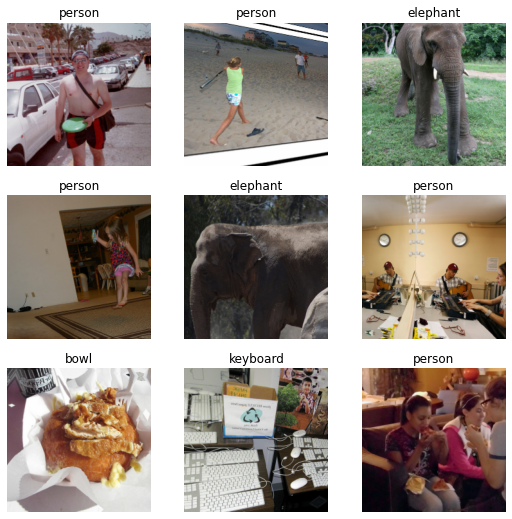

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.010964781977236271)

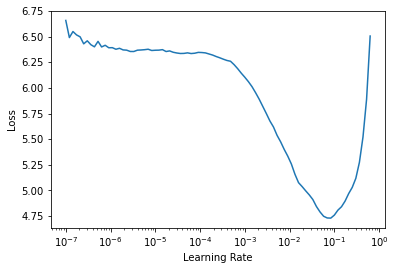

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.104939,1.354830,0.664783,00:22


epoch,train_loss,valid_loss,accuracy,time
0,1.864617,2.209740,0.534840,00:29
1,1.707585,1.604073,0.591337,00:29
2,1.323048,1.254978,0.630885,00:29
3,0.982932,1.127202,0.679849,00:29


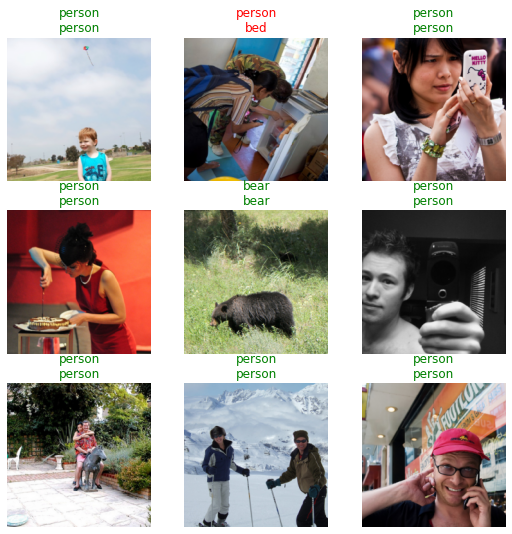

In [ ]:
learn.fine_tune(4, 2e-2)
learn.show_results()

In [ ]:
                                                # eof






































